In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
pip install -q -U tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


In [4]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


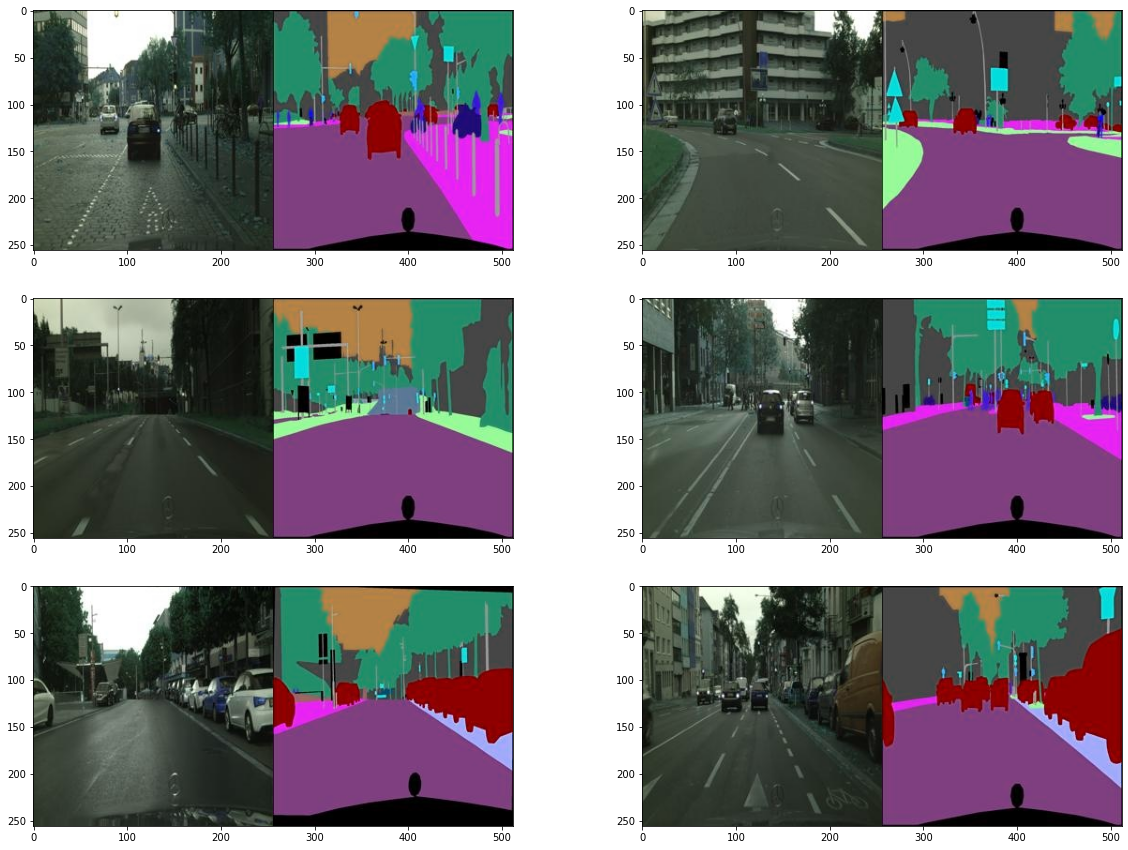

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [6]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


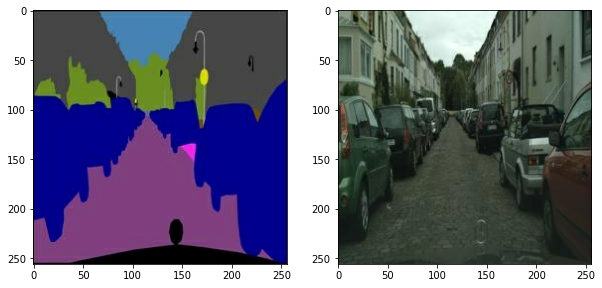

In [7]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3) #3채널 - Number of color channels for the decoded image.
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w , :] 
    colored = tf.cast(colored, tf.float32)
    
    return normalize(sketch), normalize(colored)


f = data_path + os.listdir(data_path)[1]
sketch , colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


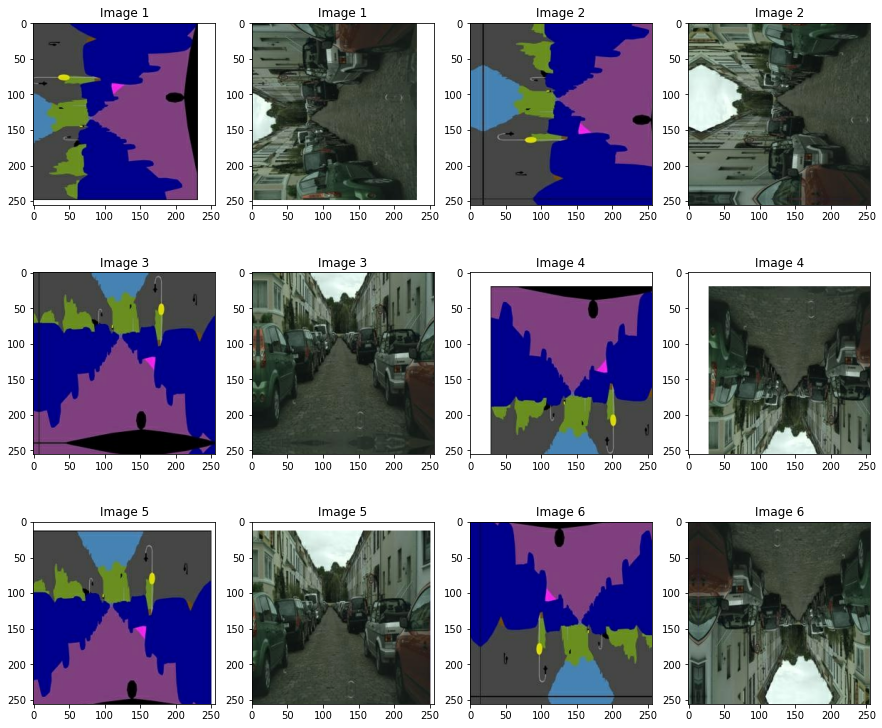

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

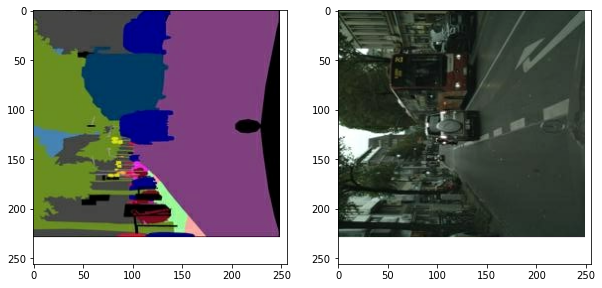

In [10]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [13]:
from tensorflow.keras import layers, Input, Model

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [16]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [18]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [19]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [20]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [21]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [22]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [23]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9731                     
L1_loss:0.3112                     
Discriminator_loss:1.2770

EPOCH[1] - STEP[20]                     
Generator_loss:0.9315                     
L1_loss:0.2315                     
Discriminator_loss:1.2954

EPOCH[1] - STEP[30]                     
Generator_loss:0.7940                     
L1_loss:0.2391                     
Discriminator_loss:1.4705

EPOCH[1] - STEP[40]                     
Generator_loss:0.7698                     
L1_loss:0.2228                     
Discriminator_loss:1.2450

EPOCH[1] - STEP[50]                     
Generator_loss:0.7579                     
L1_loss:0.1561                     
Discriminator_loss:1.1740

EPOCH[1] - STEP[60]                     
Generator_loss:1.0759                     
L1_loss:0.2129                     
Discriminator_loss:1.2584

EPOCH[1] - STEP[70]                     
Generator_loss:1.0697                     
L1_loss:0.1897                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.7154                     
L1_loss:0.1699                     
Discriminator_loss:0.4846

EPOCH[3] - STEP[80]                     
Generator_loss:3.0701                     
L1_loss:0.1787                     
Discriminator_loss:0.4503

EPOCH[3] - STEP[90]                     
Generator_loss:2.4868                     
L1_loss:0.1614                     
Discriminator_loss:2.0470

EPOCH[3] - STEP[100]                     
Generator_loss:1.4932                     
L1_loss:0.2337                     
Discriminator_loss:0.3932

EPOCH[3] - STEP[110]                     
Generator_loss:0.9451                     
L1_loss:0.1840                     
Discriminator_loss:0.7947

EPOCH[3] - STEP[120]                     
Generator_loss:2.8005                     
L1_loss:0.1609                     
Discriminator_loss:1.2181

EPOCH[3] - STEP[130]                     
Generator_loss:2.1076                     
L1_loss:0.1739                

EPOCH[5] - STEP[130]                     
Generator_loss:0.7227                     
L1_loss:0.1619                     
Discriminator_loss:0.8113

EPOCH[5] - STEP[140]                     
Generator_loss:1.9715                     
L1_loss:0.2153                     
Discriminator_loss:0.3417

EPOCH[5] - STEP[150]                     
Generator_loss:2.1383                     
L1_loss:0.1934                     
Discriminator_loss:0.3670

EPOCH[5] - STEP[160]                     
Generator_loss:2.1095                     
L1_loss:0.1839                     
Discriminator_loss:0.4793

EPOCH[5] - STEP[170]                     
Generator_loss:0.7231                     
L1_loss:0.1586                     
Discriminator_loss:1.0557

EPOCH[5] - STEP[180]                     
Generator_loss:1.3017                     
L1_loss:0.1815                     
Discriminator_loss:1.1234

EPOCH[5] - STEP[190]                     
Generator_loss:2.6709                     
L1_loss:0.1610             

EPOCH[7] - STEP[190]                     
Generator_loss:2.3178                     
L1_loss:0.1640                     
Discriminator_loss:0.8834

EPOCH[7] - STEP[200]                     
Generator_loss:0.6628                     
L1_loss:0.1754                     
Discriminator_loss:2.7713

EPOCH[7] - STEP[210]                     
Generator_loss:3.0011                     
L1_loss:0.1612                     
Discriminator_loss:1.7524

EPOCH[7] - STEP[220]                     
Generator_loss:0.4525                     
L1_loss:0.2077                     
Discriminator_loss:2.8149

EPOCH[7] - STEP[230]                     
Generator_loss:1.3231                     
L1_loss:0.1946                     
Discriminator_loss:0.4306

EPOCH[7] - STEP[240]                     
Generator_loss:2.1365                     
L1_loss:0.1986                     
Discriminator_loss:0.9324

EPOCH[7] - STEP[250]                     
Generator_loss:1.7291                     
L1_loss:0.1726             

EPOCH[9] - STEP[250]                     
Generator_loss:2.5001                     
L1_loss:0.1602                     
Discriminator_loss:1.8796

EPOCH[10] - STEP[10]                     
Generator_loss:1.4399                     
L1_loss:0.1485                     
Discriminator_loss:1.2860

EPOCH[10] - STEP[20]                     
Generator_loss:1.9983                     
L1_loss:0.1460                     
Discriminator_loss:1.8750

EPOCH[10] - STEP[30]                     
Generator_loss:1.7033                     
L1_loss:0.1498                     
Discriminator_loss:0.7387

EPOCH[10] - STEP[40]                     
Generator_loss:1.2974                     
L1_loss:0.2126                     
Discriminator_loss:1.0048

EPOCH[10] - STEP[50]                     
Generator_loss:1.6991                     
L1_loss:0.1747                     
Discriminator_loss:1.1775

EPOCH[10] - STEP[60]                     
Generator_loss:1.5680                     
L1_loss:0.1672             

In [27]:
val_data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of train examples :", len(os.listdir(val_data_path)))

number of train examples : 5


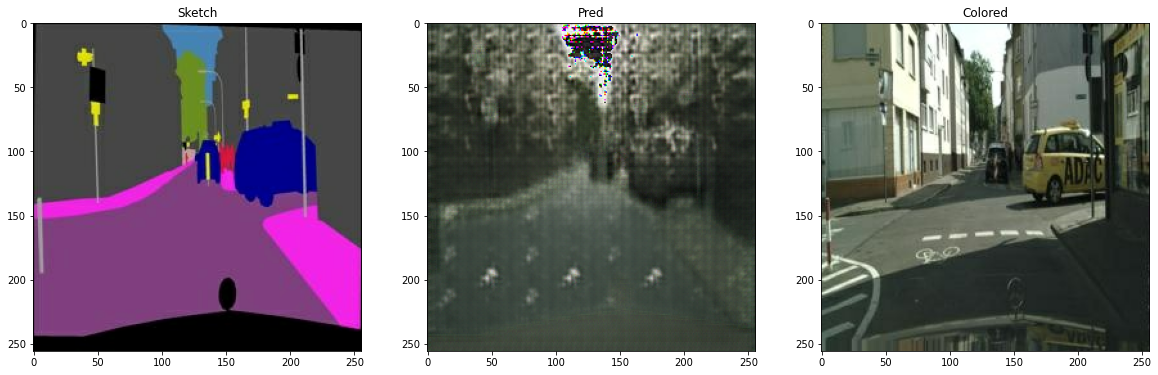

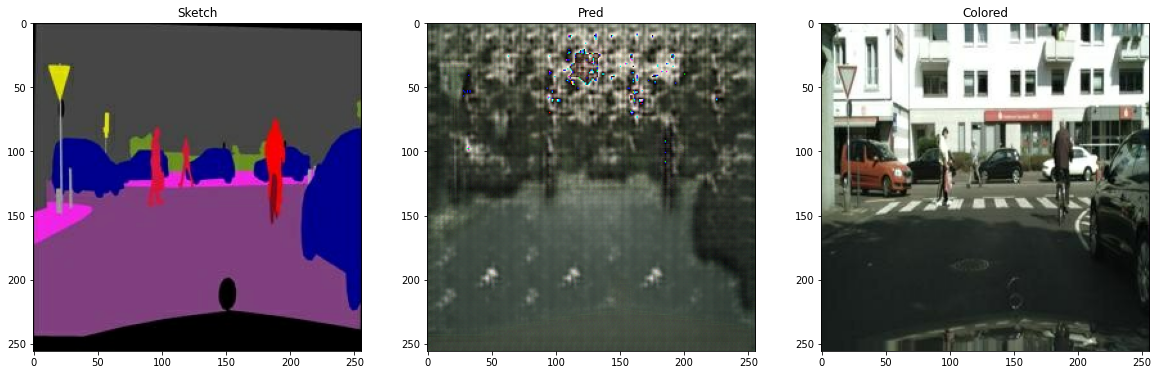

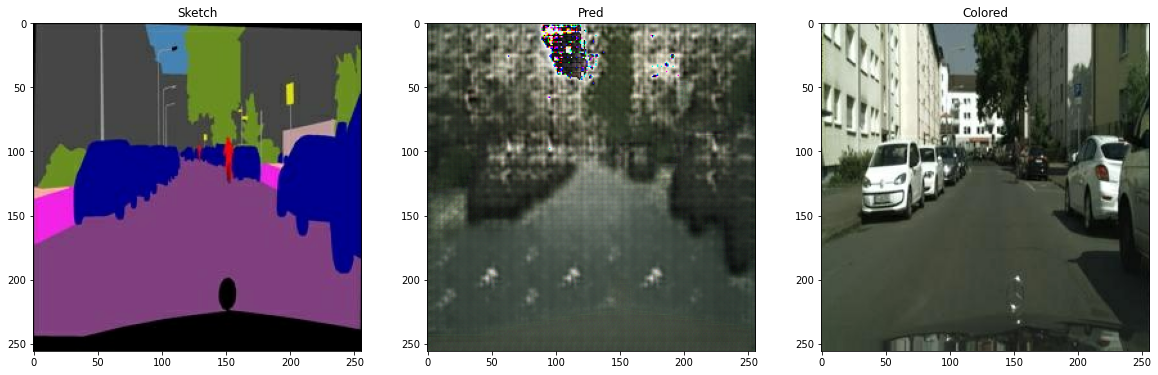

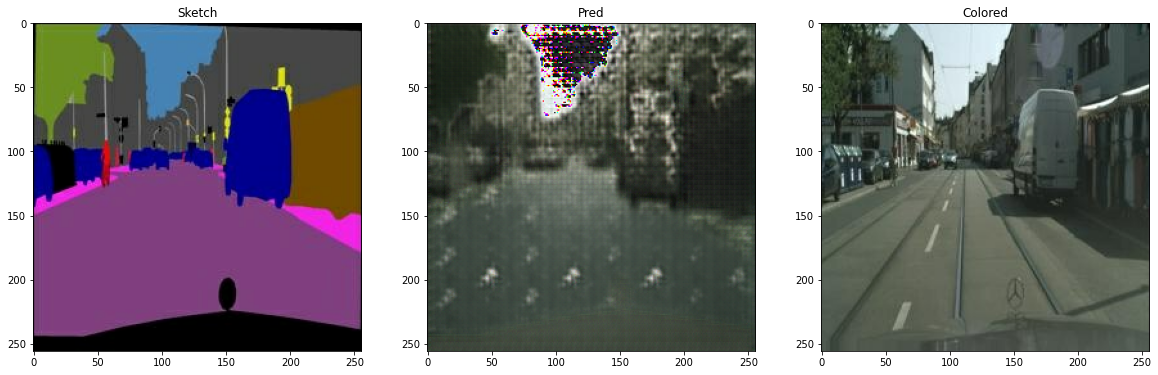

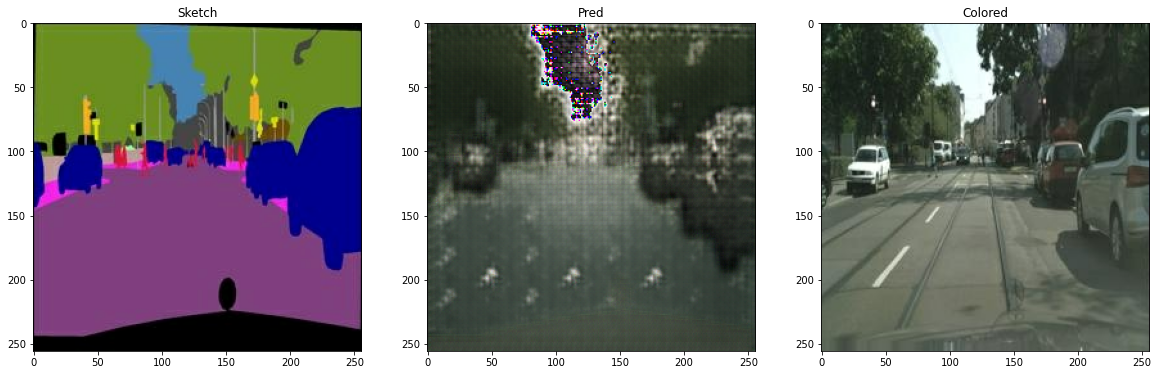

In [31]:
# Val 이미지 5장 테스트 하기

for i in range(5):
    
    f = val_data_path + os.listdir(val_data_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch)) ; plt.title('Sketch')
    plt.subplot(1,3,2); plt.imshow(pred[0]) ; plt.title('Pred')
    plt.subplot(1,3,3); plt.imshow(denormalize(colored)) ; plt.title('Colored')
    
    

## 회고:
GAN 관련된 노드를 처음 접했을 때 생소하고 흥미로우면서도 어려웠던 기억이 난다. 이번 노드를 하면서도 같은 생각을 하며 진행한 것 같다. 
GAN 의 기본 컨셉은 원하는 이미지를 얻기까지 시간과 노력이 많이 들어갈 수 있다는 점을 생각하지 못했었는데, 그리하여 cGAN 이 생겨났다고 하여 찾아보니 많은 종류의 GAN 모델이 있음을 알게되었다. (CycleGAN 등) 
10 Epoch 만 돌려서 결과 퀄리티가 별로 좋지는 않았지만 실습을 해보면서 모델을 좀 더 이해해보는데 의미를 두었다. 
마지막으로 노드 내용에서 알게된 네이버 AI painter를 해봤는데 그림을 못그리는 나 같은 사람도 아이디어를 시각적으로 표현할 수 있겠다는 생각이 들었다. 